In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

finviz_url = "https://finviz.com/quote.ashx?t="

tickers = ["AAPL", "BAC", "NVDA"]  # tickers of high-volume stocks

news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
    res = urlopen(req)
    html = BeautifulSoup(res, "html.parser")
    news_table = html.find(id="news-table")
    news_tables[ticker] = news_table


In [2]:
parsed_data = []

for ticker, news_table in news_tables.items():
    allrows = news_table.find_all("tr")
    print("Getting news of " + ticker + ": " + str(len(allrows)))
    for row in allrows:
        title = row.a.text
        date_data = row.td.text.split(" ")

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        text = "" 
        try:
            url = row.a.get("href")
            if not url.startswith(("https://www.investors.com","https://www.thestreet.com","https://realmoney.thestreet.com")):
                # the above urls are not banned from scraping
                req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
                res = urlopen(req)
                html = BeautifulSoup(res, "html.parser")
                text = html.get_text()
        except Exception as e:
            print("An " + str(e) + " occurred on " + url)
        

        parsed_data.append([ticker, date, time, title, text])



Getting news of AAPL: 100
Getting news of BAC: 100
Getting news of NVDA: 100


In [3]:
df = pd.DataFrame(parsed_data, columns=["ticker", "date", "time", "title", "text"])
df.head()

,ticker,date,time,title,text
0,AAPL,May-03-22,06:07PM,Generals Marching Without Soldiers,Generals Marching Without Soldiers HOM...
1,AAPL,May-03-22,05:10PM,From Amazon to Yelp: The companies taking a st...,From Amazon to Yelp: The companies taking a st...
2,AAPL,May-03-22,04:56PM,Dizzying Pre-Fed Day Ends With Gains for Stock...,Dizzying Pre-Fed Day Ends With Gains for Stock...
3,AAPL,May-03-22,04:56PM,What a Peloton Acquisition Would Mean for Appl...,\n\n\n\n\n\n What a Peloton Acquisition W...
4,AAPL,May-03-22,04:16PM,"Apples App Store Offers Reasons for Hope, Anal...",\n\n\n\n\n\n There Are Good Signs for App...


<Figure size 1152x648 with 0 Axes>

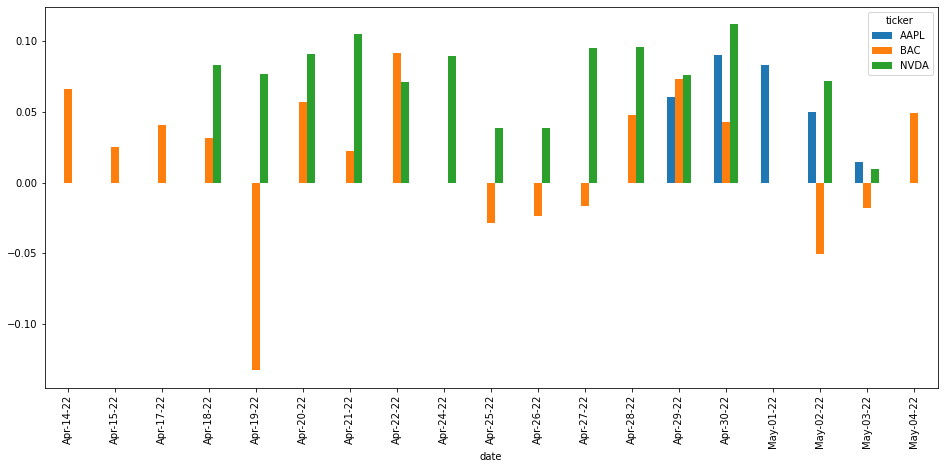

In [13]:
vader = SentimentIntensityAnalyzer()

# compound is not suitable for this case
def analyze(text):
    pos = vader.polarity_scores(text)["pos"]
    neg = vader.polarity_scores(text)["neg"]
    return pos-neg
df["score"] = df["text"].apply(analyze)
df["date"] == pd.to_datetime(df.date).dt.date


plt.figure(figsize=(16, 9))
plt.rcParams['figure.figsize'] = [16, 7]

mean_df = df.groupby(["ticker", "date"]).mean()
mean_df = mean_df.unstack()
mean_df = mean_df.xs("score", axis="columns").transpose()
mean_df.plot(kind="bar")
plt.show()